In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Use this for Google Colab

def detectAndDescribe(image, method='sift'):
    # Detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    else:
        raise ValueError("Invalid feature detection method. Supported values are: 'sift', 'surf'")

    # Get keypoints and descriptors
    kp, des = descriptor.detectAndCompute(image, None)

    return kp, des


In [19]:
def matchKeyPointsBF(featuresA, featuresB, method='sift'):
    # Brute-Force Matcher
    bf = cv2.BFMatcher()

    # Match descriptors
    matches = bf.knnMatch(featuresA, featuresB, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return good_matches


In [20]:
def matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method='sift'):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors
    matches = flann.knnMatch(featuresA, featuresB, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    return good_matches

In [21]:
def visualize_matches(trainImg, kpsA, queryImg, kpsB, matches):
    img3 = cv2.drawMatches(trainImg, kpsA, queryImg, kpsB, matches[:100],
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2_imshow(img3)  # Use this for Google Colab

In [22]:
def create_panorama(img1, img2, method='sift'):
    # Detect and describe features in the images
    kp1, des1 = detectAndDescribe(img1, method)
    kp2, des2 = detectAndDescribe(img2, method)

    # Match features between the images
    matches = matchKeyPointsBF(des1, des2, method)

    # Convert matches to points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Apply RANSAC to find the homography matrix
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp the first image onto the second image
    result = cv2.warpPerspective(img1, H, (img2.shape[1] + img1.shape[1], img2.shape[0]))

    # Copy the second image onto the result image
    result[0:img2.shape[0], 0:img2.shape[1]] = img2

    return result


In [31]:
# Example usage
feature_matching = 'bf'  # or 'knn'
feature_extractor = 'sift'  # or 'surf', depending on your feature extraction method

# Replace these with your actual images
trainImg1 = cv2.imread('vr2.jpeg')
trainImg2 = cv2.imread('vr3.jpeg')

# Feature detection and description
kpsA, featuresA = detectAndDescribe(trainImg1, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(trainImg2, method=feature_extractor)




Using: bf feature matcher


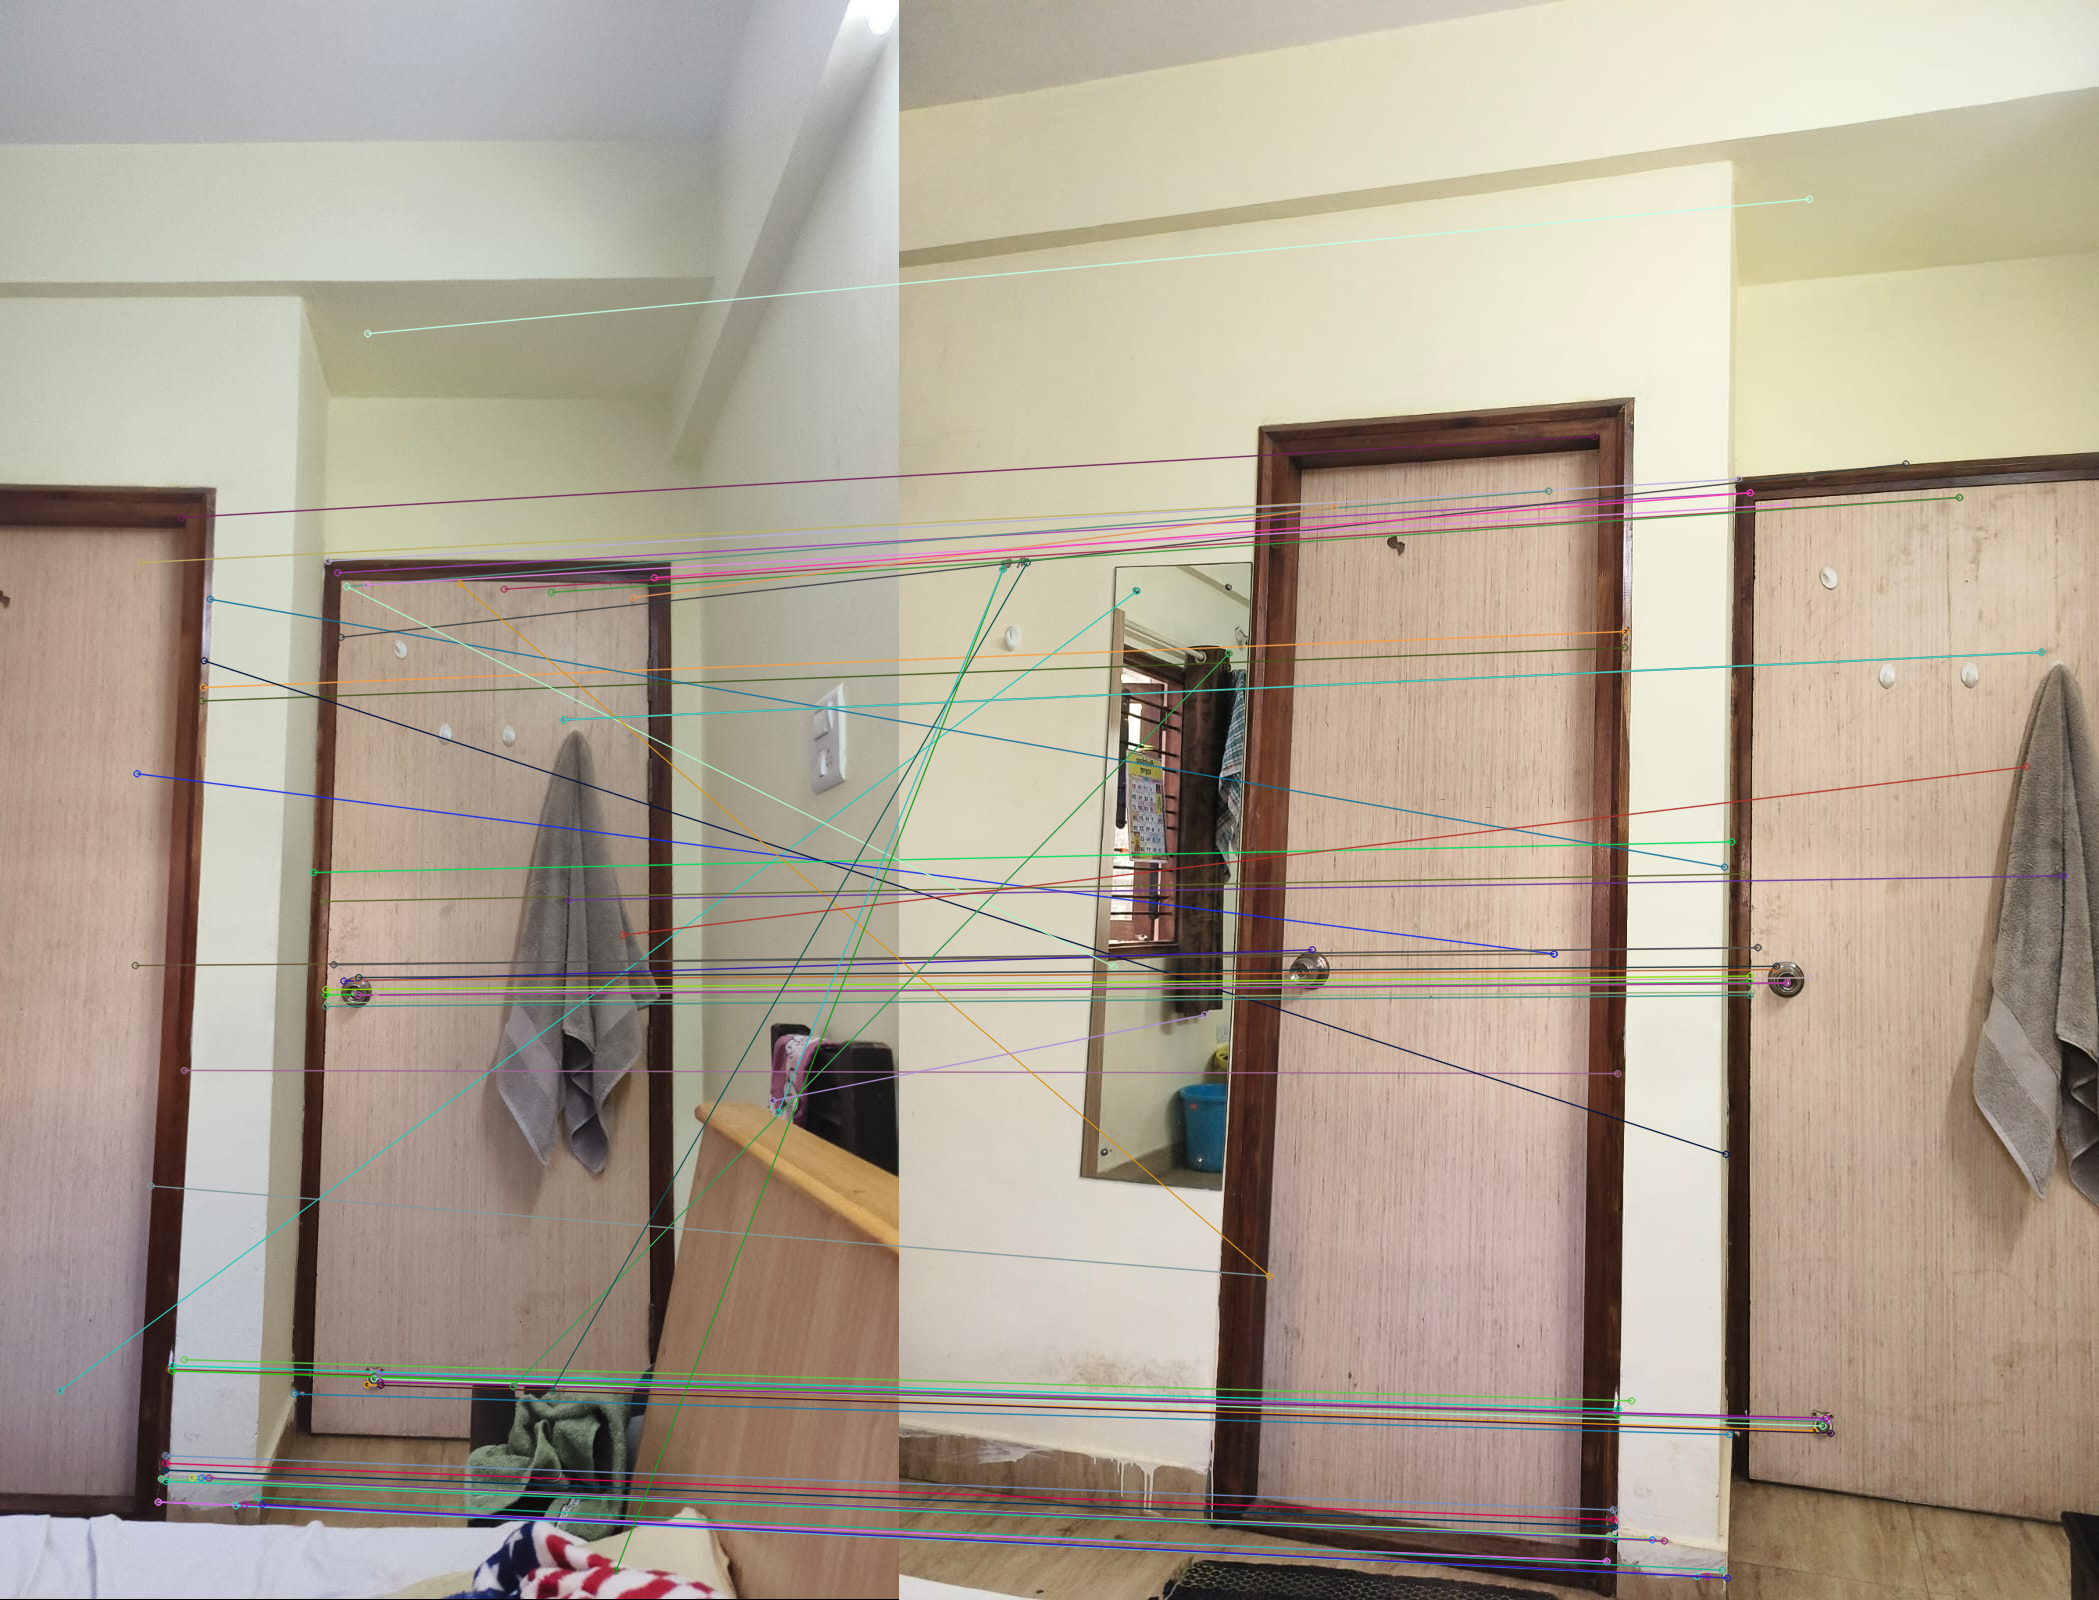

In [32]:
print("Using: {} feature matcher".format(feature_matching))

# Feature matching
if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

# Visualization
visualize_matches(trainImg1, kpsA, trainImg2, kpsB, matches)



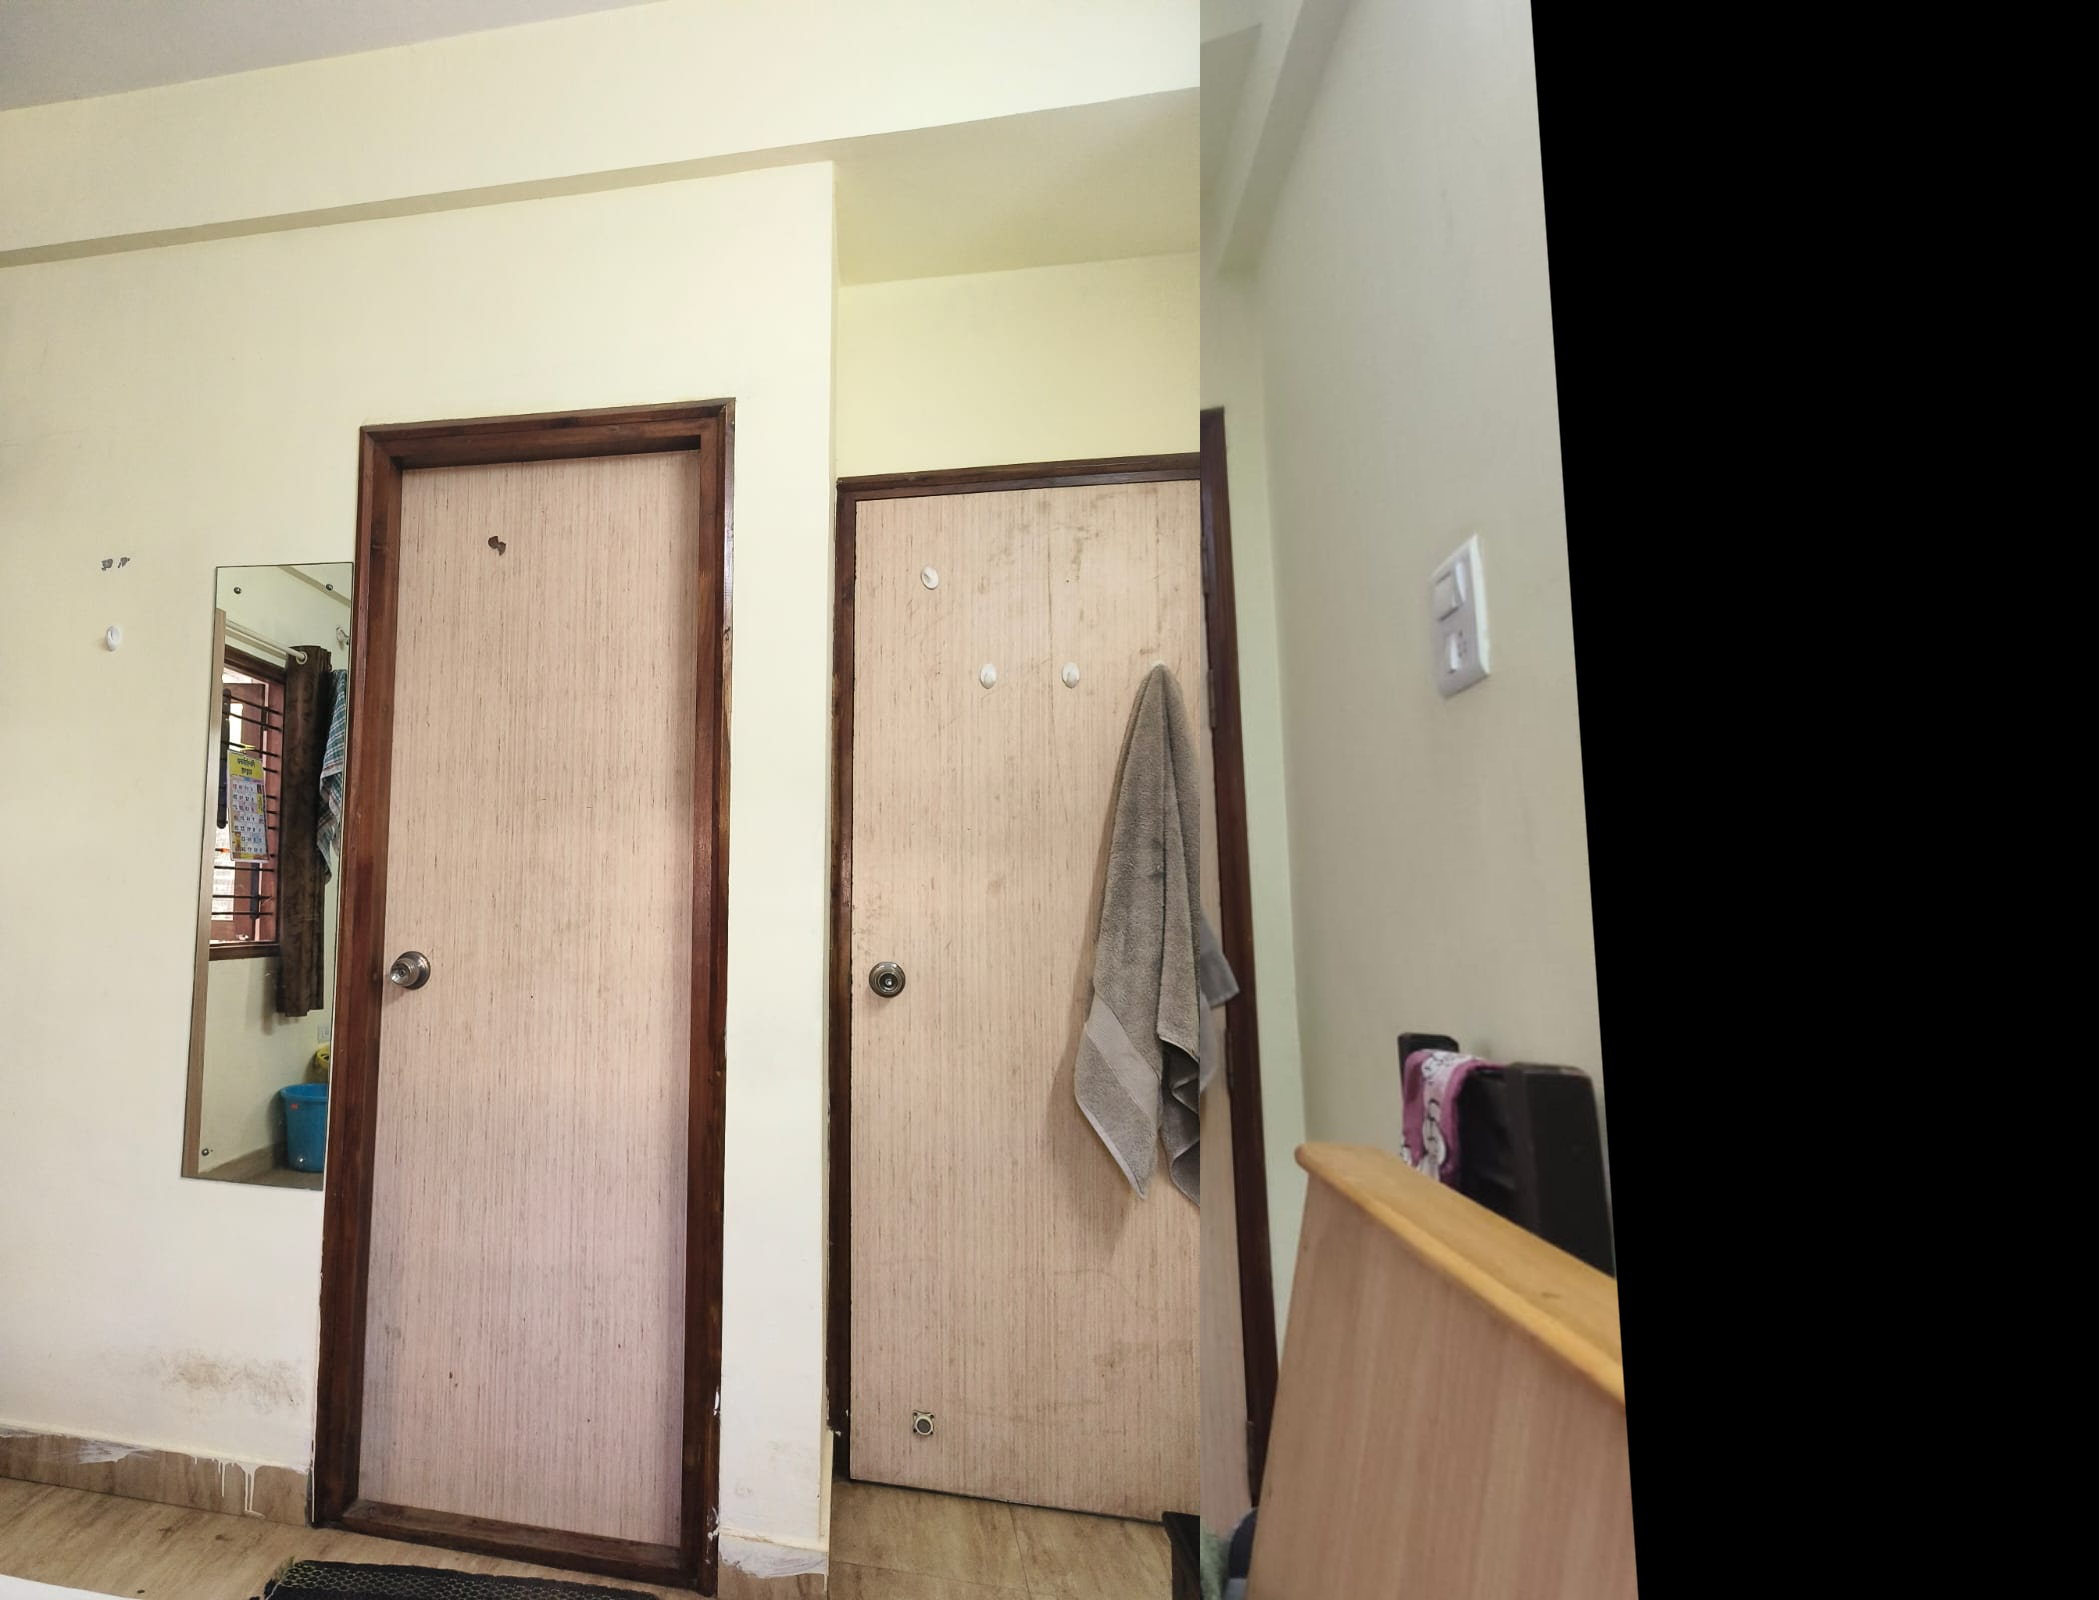

In [33]:
# Create panorama
panorama_result = create_panorama(trainImg1, trainImg2, method=feature_extractor)

# Display panorama
cv2_imshow(panorama_result)  # Use this for Google Colab